# 2. Chemical Space and Drug-Likeness Evaluation

This notebook compares the chemical space of drugs captured in our dataset against all drugs which have reached Phase IV of development on ChEMBL using both a structure-based and a descriptor-based projection. It also compares the chemical space against "druggable" space as defined by drug-likeness rules

In [2]:
# Cheminformatics libraries
from chembl_structure_pipeline import standardizer
from rdkit import Chem
from rdkit.Chem import Descriptors, inchi, MACCSkeys, DataStructs, PandasTools, Lipinski
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt

# Web scraping libraries
from chembl_webresource_client.new_client import new_client
from chembl_webresource_client.settings import Settings
import requests

# Other necessary libraries
import ast
import regex as re
import warnings
warnings.filterwarnings("ignore")

[13:17:55] Initializing Normalizer


## Chemical Space Analysis

In [4]:
# Loading necessary .csv files
active_substance_df = pd.read_csv("../csv_files/adding_chembl_to_actives.csv")
master_df = pd.read_csv("../csv_files/final_master_df.csv")

# Generating a Series of orally administered drugs
oral_drugs_series = master_df[["actives_in_dosage_form", "Route"]]
oral_drugs_series = oral_drugs_series[oral_drugs_series["Route"]=="Oral"]
oral_drugs_series["actives_in_dosage_form"] = oral_drugs_series["actives_in_dosage_form"].apply(lambda x: x.upper().strip().split(","))
oral_drugs_series = oral_drugs_series.explode("actives_in_dosage_form")
oral_drugs_series = oral_drugs_series["actives_in_dosage_form"].apply(lambda x: x.strip())

# Integrate with active_substance_df
active_substance_df["oral"] = active_substance_df["active_PSS"].apply(lambda x: x in set(oral_drugs_series))
active_substance_df = active_substance_df[active_substance_df["oral"] == True]

# Retrieving drugs from ChEMBL, generating a dataframe called chembl_drugs_df
drug = new_client.drug.filter(oral = 1)
drugs_output = pd.DataFrame(drug)
chembl_drugs_df = drugs_output[drugs_output["molecule_structures"].notna()]
chembl_drugs_df["standard_inchi"] = chembl_drugs_df["molecule_structures"].apply(lambda x: x.get("standard_inchi", None))
chembl_drugs_df["Inchikey"] = chembl_drugs_df["molecule_structures"].apply(lambda x: x.get("standard_inchi_key", None))
chembl_drugs_df = chembl_drugs_df[["standard_inchi", "Inchikey"]]

# Removing drugs in chembl_drugs_df that have a molecular weight above 1000 and then removing unnessary columns
chembl_drugs_df["mol"] = chembl_drugs_df["standard_inchi"].apply(Chem.MolFromInchi)
chembl_drugs_df["Mw"] = chembl_drugs_df["mol"].apply(lambda x: Descriptors.MolWt(x))
chembl_drugs_df = chembl_drugs_df[chembl_drugs_df["Mw"] < 1000]
chembl_drugs_df["In_Database"] = False # Placeholder
chembl_drugs_df = chembl_drugs_df[["standard_inchi", "Inchikey", "In_Database"]]

# Giving same names to columns in EMA dataframe, then concatenating and removing duplicates by the canonical Inchikey, with EMA drugs first.
ema_drugs_df = active_substance_df[["p_inchi", "p_inchikey", "pss_inchi"]]
ema_drugs_df.rename(columns={
    "p_inchi": "standard_inchi",
    "p_inchikey": "Inchikey"
}, inplace=True)
ema_drugs_df["In_Database"] = True
df_concat = pd.concat([ema_drugs_df, chembl_drugs_df])
df_concat.drop_duplicates(subset="Inchikey", keep="first", inplace=True)

# Finally adding smiles column and getting MACCS keys for onwards analysis
df_concat["SMILES"] = df_concat["standard_inchi"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromInchi(x)))
PandasTools.AddMoleculeColumnToFrame(df_concat, smilesCol="SMILES")
df_concat["MACCS_keys"] = df_concat["ROMol"].apply(MACCSkeys.GenMACCSKeys)

In [5]:
# Generating a numpy array, distance_matrix. This describes the tanimoto distance of each parent drug molecule from
# every other molecule and will be used for t-SNE
X = list(df_concat["MACCS_keys"])
tanimoto_sim_mat_lower_triangle = GetTanimotoSimMat(X)
n_mol = len(X)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower = np.tril_indices(n = n_mol, m = n_mol, k = -1)
i_upper = np.triu_indices(n = n_mol, m = n_mol, k = 1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] # .T is to transpose the matrix as it is symmetrical about the diagonal
distance_matrix = np.subtract(1,similarity_matrix) # One is subtracted from each element of matrix as this is a distance matrix

# TSNE - Note this projection will change as ChEMBL is updated
perplexity = 50 # Determined empirically
tsne_model = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=1000)
tsne_drugs = tsne_model.fit_transform(distance_matrix)
tsne_df = pd.DataFrame(tsne_drugs)
tsne_df = tsne_df.rename(columns={0: "tSNE1", 1: "tSNE2"})
df_concat.reset_index(drop=True, inplace=True)
df_concat["tSNE1"] = tsne_df["tSNE1"]
df_concat["tSNE2"] = tsne_df["tSNE2"]

In [7]:
# To label data
ema_data = df_concat[df_concat["In_Database"] == True]
chembl_data = df_concat[df_concat["In_Database"] == False]

In [9]:
# Reducing dimensionality of all RDKit Lipinski descriptors, scaling using standardscaler.
def encode_molecule(SMILES_string):
    mol = Chem.MolFromSmiles(SMILES_string)
    mol_encoding = [Lipinski.FractionCSP3(mol), Lipinski.HeavyAtomCount(mol), Lipinski.NHOHCount(mol),
                    Lipinski.NOCount(mol), Lipinski.NumAliphaticCarbocycles(mol), Lipinski.NumAliphaticHeterocycles(mol),
                    Lipinski.NumAliphaticRings(mol), Lipinski.NumAromaticCarbocycles(mol), Lipinski.NumAromaticHeterocycles(mol),
                    Lipinski.NumAromaticRings(mol), Lipinski.NumHAcceptors(mol), Lipinski.NumHDonors(mol),
                    Lipinski.NumHeteroatoms(mol), Lipinski.NumRotatableBonds(mol), Lipinski.NumSaturatedCarbocycles(mol),
                    Lipinski.NumSaturatedHeterocycles(mol), Lipinski.NumSaturatedRings(mol), Lipinski.RingCount(mol)]
    return mol_encoding

# Similar method to above
smiles_strings = df_concat["SMILES"]
mol_encodings = [encode_molecule(smiles) for smiles in smiles_strings]
scaler = StandardScaler()
mol_encodings_scaled = scaler.fit_transform(mol_encodings)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(mol_encodings_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_concat["PC1"] = pca_df["PC1"]
df_concat["PC2"] = pca_df["PC2"]
df_concat.to_csv("../results/dimensionality_reduction.csv")

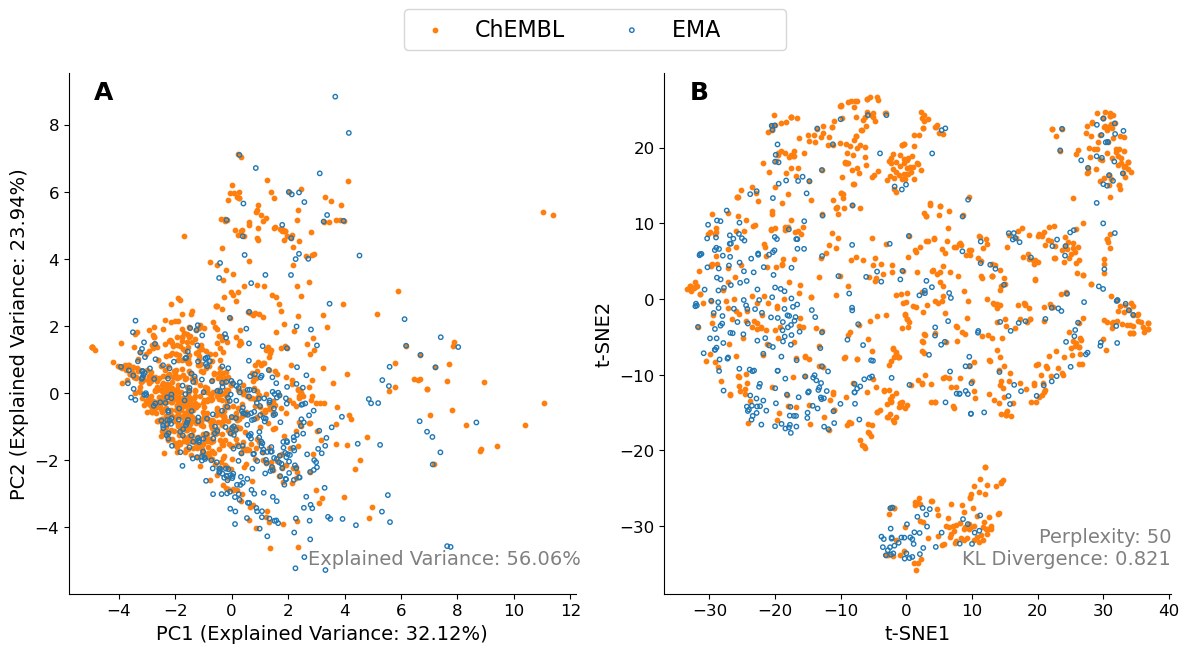

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# For Legend
ema_data = df_concat[df_concat["In_Database"] == True]
chembl_data = df_concat[df_concat["In_Database"] == False]

# Plot 1: PCA
axs[0].scatter(chembl_data["PC1"], chembl_data["PC2"], color="C1", s=10, marker="o")
axs[0].scatter(ema_data["PC1"], ema_data["PC2"], color="none", s=10, marker="o", edgecolor="C0")
axs[0].set_xlabel(f"PC1 (Explained Variance: {pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=14)
axs[0].set_ylabel(f"PC2 (Explained Variance: {pca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=14)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].text(1.01, 0.05, f"Explained Variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%", fontsize=14, color="gray", ha="right", va="bottom", transform=axs[0].transAxes)
axs[0].text(0.05, 0.95, "A", fontsize=18, fontweight="bold", transform=axs[0].transAxes)
axs[0].tick_params(axis='both', which='major', labelsize=12)

# Plot 2: tSNE
axs[1].scatter(chembl_data["tSNE1"], chembl_data["tSNE2"], label="ChEMBL", color="C1", s=10, marker="o")
axs[1].scatter(ema_data["tSNE1"], ema_data["tSNE2"], label="EMA        ", color="none", s=10, marker="o", edgecolor="C0")
axs[1].set_xlabel("t-SNE1", fontsize=14)
axs[1].set_ylabel("t-SNE2", fontsize=14)
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].text(1, 0.05, f"Perplexity: {perplexity}\nKL Divergence: {tsne_model.kl_divergence_:.3f}", fontsize=14, color="gray", ha="right", va="bottom", transform=axs[1].transAxes)
axs[1].text(0.05, 0.95, "B", fontsize=18, fontweight="bold", transform=axs[1].transAxes)
axs[1].tick_params(axis='both', which='major', labelsize=12)

fig.legend(frameon=True, loc="upper center", bbox_to_anchor=(0.5,1.1), ncol=2, fontsize=16)
plt.tight_layout()
plt.savefig("../figures/ChemicalSpace.pdf", bbox_inches="tight")
plt.show()

## Drug Likeness Evaluation

Task two: Normalised boxplots comparing EMA data to existing drug-likeness rulesets, including:
* The Rule of Five (10.1016/S0169-409X(00)00129-0)
    * LogP ≤ 5
    * MolWt ≤ 500
    * HBA ≤ 10
    * HBD ≤ 5
* The Extended Rule of (10.1016/j.chembiol.2014.08.013)
    * MW ≤ 700
    * 0 ≤ LogP ≤ 7.5
    * HBD ≤ 5
    * PSA ≤ 200 Å2
    * RBC ≤ 20
* Veber's Rules  (10.1021/jm020017n)
    * RBC ≤ 10
    * TPSA < 140
* The Contemporary Rule of Five (10.1080/17460441.2023.2275617 - these authors perform a similar analysis but apply different limites
* for some of the rules referenced above.)
    * HBD ≤ 4
    * HBA ≤ 11
    * MolWt ≤ 605
    * LogP ≤ 5.4
    * TPSA ≤ 153
    * RBC ≤ 11
    
We therefore need MolWt, HBD, HBA, RBC, TPSA, MolLogP (the Wildman-Crippin calculation of LogP)

In [54]:
# Remove duplicates of the parent drug on the canonical inchikey
active_substance_no_duplicates = active_substance_df.drop_duplicates(subset=["p_inchikey"], keep="first", inplace=False)[["Substance_Name", "ps_smiles", "ps_num_drugs", "p_inchi", "p_smiles"]]
active_substance_no_duplicates.reset_index(inplace=True)
descriptors = ["MolWt", "HBD", "HBA", "RBC","TPSA", "MolLogP"]
def get_likeness_rules(inchistring):
    mol = Chem.MolFromInchi(inchistring)
    if mol:
        return [
            Descriptors.MolWt(mol),    # Molecular Weight
            Lipinski.NumHDonors(mol),   # Number of Hydrogen Bond Donors
            Lipinski.NumHAcceptors(mol),   # Number of Hydrogen Bond Acceptors
            Descriptors.NumRotatableBonds(mol), # Rotatable bonds
            Descriptors.TPSA(mol),     # Topological Polar Surface Area - eRo5 refers to polar surface area but this was confired to be topological
            Descriptors.MolLogP(mol)   # LogP (Partition Coefficient)
        ]
    else:
        # Return a list of NaNs if the molecule cannot be created
        return [float("nan")] * len(descriptors)
likeness = [get_likeness_rules(inchi) for inchi in active_substance_no_duplicates["p_inchi"]]
for i, descriptor in enumerate(descriptors):
    active_substance_no_duplicates[descriptor] = [row[i] for row in likeness]
# Next line removes iron salts etc. May result in escape sequence warning
drug_likeness_df = active_substance_no_duplicates[~active_substance_no_duplicates["p_smiles"].str.contains("\.")] 
# Getting the molecular weight of the desolvated active ingredients and then dividing by the number of drugs (e.g. in the case of estradiol hemihydrate)
drug_likeness_df["PSMolWt"] = drug_likeness_df["ps_smiles"].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
drug_likeness_df["PSMolWt"] = drug_likeness_df["PSMolWt"]/drug_likeness_df["ps_num_drugs"]

[13:44:35] WARNING: not removing hydrogen atom without neighbors


In [56]:
# Normalise against Ro5
drug_likeness_df["PSMolWtRo5"] = drug_likeness_df["PSMolWt"]/500
drug_likeness_df["MolWtRo5"] = drug_likeness_df["MolWt"]/500
drug_likeness_df["HBDRo5"] = drug_likeness_df["HBD"]/5
drug_likeness_df["HBARo5"] = drug_likeness_df["HBA"]/10
drug_likeness_df["MolLogPRo5"] = drug_likeness_df["MolLogP"]/5

# Normalise against Veber's Rules
drug_likeness_df["RBCVR"] = drug_likeness_df["RBC"]/10
drug_likeness_df["TPSAVR"] = drug_likeness_df["TPSA"]/140

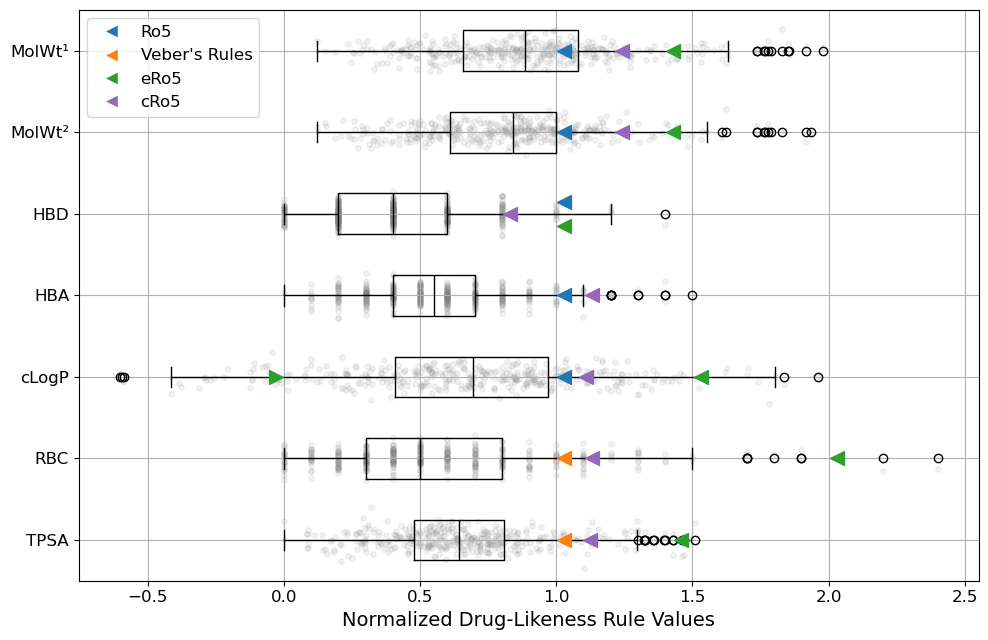

In [104]:
normalised_variables = ["TPSAVR", "RBCVR", "MolLogPRo5", "HBARo5", "HBDRo5", "MolWtRo5", "PSMolWtRo5"]
my_names = ["TPSA", "RBC", "cLogP", "HBA", "HBD", "MolWt\u00B2", "MolWt\u00B9"]

plt.figure(figsize=(10, 6.5))  
bp = plt.boxplot(drug_likeness_df[normalised_variables], 
                 vert=False, 
                 medianprops={"color": "black"},  # Set median line color and width
                 zorder=2)  # Set zorder to 1 for the boxplots

for i, var in enumerate(normalised_variables):
    y = np.random.normal(i + 1, 0.1, size=len(drug_likeness_df[var]))
    plt.scatter(drug_likeness_df[var], y, color="gray", alpha=0.1, s=15, zorder=1)  # Set zorder to 2 for the scatter points

# Scatter plots for rules
# Lipinski
plt.scatter(1.03, 7, color="C0", marker="<", s=100, zorder=3) 
plt.scatter(1.03, 6, color="C0", marker="<", s=100, zorder=3)  
plt.scatter(1.03, 5.15, color="C0", marker="<", s=100, zorder=3)  
plt.scatter(1.03, 4, color="C0", marker="<", s=100, zorder=3) 
plt.scatter(1.03, 3, color="C0", marker="<", s=100, zorder=3)  

# Veber
plt.scatter(1.03, 2, color="C1", marker="<", s=100, zorder=3)  
plt.scatter(1.03, 1, color="C1", marker="<", s=100, zorder=3)  

# eRo5
plt.scatter((700/500 + 0.03), 7, color="C2", marker="<", s=100, zorder=3)
plt.scatter((700/500 + 0.03), 6, color="C2", marker="<", s=100, zorder=3)  
plt.scatter(1.03, 4.85, color="C2", marker="<", s=100, zorder=3)  
plt.scatter((7.5/5 + 0.03), 3, color="C2", marker="<", s=100, zorder=3)
plt.scatter(-0.03, 3, color="C2", marker=">", s=100, zorder=3)
plt.scatter((200/140 + 0.03), 1, color="C2", marker="<", s=100, zorder=3)  
plt.scatter((20/10 + 0.03), 2, color="C2", marker="<", s=100, zorder=3)  

# cRo5
plt.scatter((605/500 + 0.03), 7, color="C4", marker="<", s=100, zorder=3)  
plt.scatter((605/500 + 0.03), 6, color="C4", marker="<", s=100, zorder=3)  
plt.scatter((4/5 + 0.03), 5, color="C4", marker="<", s=100, zorder=3)  
plt.scatter((11/10 + 0.03), 4, color="C4", marker="<", s=100, zorder=3) 
plt.scatter((5.4/5 + 0.03), 3, color="C4", marker="<", s=100, zorder=3) 
plt.scatter((11/10 + 0.03), 2, color="C4", marker="<", s=100, zorder=3)  
plt.scatter((153/140 + 0.03), 1, color="C4", marker="<", s=100, zorder=3)  

plt.xlabel("Normalized Drug-Likeness Rule Values", fontsize=14)
plt.yticks(range(1, len(normalised_variables) + 1), my_names, fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend([Line2D([0], [0], marker="<", color="w", markerfacecolor="C0", markersize=10),
            Line2D([0], [0], marker="<", color="w", markerfacecolor="C1", markersize=10),
            Line2D([0], [0], marker="<", color="w", markerfacecolor="C2", markersize=10),
            Line2D([0], [0], marker="<", color="w", markerfacecolor="C4", markersize=10)],
           ["Ro5", "Veber's Rules", "eRo5", "cRo5"], loc="upper left", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/likeness.pdf")
plt.show()

In [45]:
Ro51 = drug_likeness_df["MolWt"] <= 500
Ro52 = drug_likeness_df["HBD"] <= 5
Ro53 = drug_likeness_df["HBA"] <= 10
Ro54 = drug_likeness_df["MolLogP"] <= 5

VR1 = drug_likeness_df["TPSA"] <= 140
VR2 = drug_likeness_df["RBC"] <= 10

eRo51 = drug_likeness_df["MolWt"] <= 700
eRo52 = drug_likeness_df["HBD"] <= 5
eRo53 = ((drug_likeness_df["MolLogP"] >= 0) & (drug_likeness_df["MolLogP"] <=7.5))
eRo54 = drug_likeness_df["TPSA"] <= 200
eRo55 = drug_likeness_df["RBC"] <= 20

cRo51 = drug_likeness_df["MolWt"] <= 605
cRo52 = drug_likeness_df["HBD"] <= 4
cRo53 = drug_likeness_df["HBA"] <= 11
cRo54 = drug_likeness_df["MolLogP"] <= 5.4
cRo55 = drug_likeness_df["TPSA"] <= 153
cRo56= drug_likeness_df["RBC"] <= 11

rules_df = pd.DataFrame({
    "Ro51": Ro51,
    "Ro52": Ro52,
    "Ro53": Ro53,
    "Ro54": Ro54,
    "VR1": VR1,
    "VR2": VR2,
    "eRo51": eRo51,
    "eRo52": eRo52,
    "eRo53": eRo53,
    "eRo54": eRo54,
    "eRo55": eRo55,
    "cRo51": cRo51,
    "cRo52": cRo52,
    "cRo53": cRo53,
    "cRo54": cRo54,
    "cRo55": cRo55,
    "cRo56": cRo56,
})

rules_df["Ro5_violations"] = 4 - rules_df[["Ro51", "Ro52", "Ro53", "Ro54"]].sum(axis=1)
rules_df["VR_violations"] = 2 - rules_df[["VR1", "VR2"]].sum(axis=1)
rules_df["eRo5_violations"] = 5 - rules_df[["eRo51", "eRo52", "eRo53", "eRo54", "eRo55"]].sum(axis=1)
rules_df["cRo5_violations"] = 6 - rules_df[["cRo51", "cRo52", "cRo53", "cRo54", "cRo55", "cRo56"]].sum(axis=1)

Ro5_counts = rules_df["Ro5_violations"].value_counts().sort_index()
VR_counts = rules_df["VR_violations"].value_counts().sort_index()
eRo5_counts = rules_df["eRo5_violations"].value_counts().sort_index()
cRo5_counts = rules_df["cRo5_violations"].value_counts().sort_index()

print("Ro5 Violations Counts:", Ro5_counts)
print("\nVR Violations Counts:", VR_counts)
print("\neRo5 Violations Counts:", eRo5_counts)
print("\ncRo5 Violations Counts:", cRo5_counts)

Ro5 Violations Counts: Ro5_violations
0    252
1     78
2     61
3      3
Name: count, dtype: int64

VR Violations Counts: VR_violations
0    323
1     48
2     23
Name: count, dtype: int64

eRo5 Violations Counts: eRo5_violations
0    334
1     45
2     14
3      1
Name: count, dtype: int64

cRo5 Violations Counts: cRo5_violations
0    284
1     68
2     15
3     17
4      7
5      3
Name: count, dtype: int64


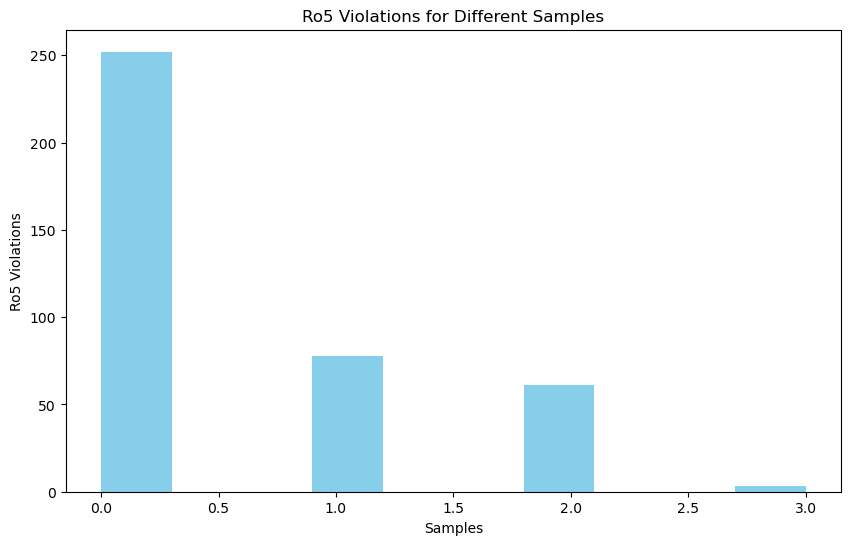

In [47]:
# Plotting bar chart for Ro5 violations
plt.figure(figsize=(10, 6))
plt.hist( rules_df["Ro5_violations"], color="skyblue")
plt.xlabel("Samples")
plt.ylabel("Ro5 Violations")
plt.title("Ro5 Violations for Different Samples")
plt.show()